In [1]:
!pip -q install pandas numpy scikit-learn ipywidgets

import math, json, re, time, os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets
from IPython.display import display, clear_output

pd.set_option("display.max_colwidth", 200)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [2]:
# === 1. Load and clean ===
PATH = "Coursera.csv"  # ensure file exists in working dir
df = pd.read_csv(PATH, engine="python")
df

,partner,course,skills,rating,reviewcount,level,certificatetype,duration,crediteligibility
0,Google,Google Cybersecurity,"{"" Network Security"","" Python Programming"","" Linux"","" Cloud Computing"","" Algorithms"","" Audit"","" Computer Programming"","" Computer Security Incident Management"","" Cryptography"","" Databases"","" Leader...",4.8,16.4k,Beginner,Professional Certificate,3 - 6 Months,False
1,Google,Google Data Analytics,"{"" Data Analysis"","" R Programming"","" SQL"","" Business Communication"","" Spreadsheet Software"","" Business Analysis"","" Data Visualization"","" Data Management"","" General Statistics"","" Big Data"","" Commun...",4.8,133.4k,Beginner,Professional Certificate,3 - 6 Months,True
2,Google,Google Project Management:,"{"" Project Management"","" Strategy and Operations"","" Leadership and Management"","" Communication"","" Business Communication"","" Collaboration"","" Agile Software Development"","" Software Engineering"","" E...",4.8,97.3k,Beginner,Professional Certificate,3 - 6 Months,True
3,Google,Google Digital Marketing & E-commerce,"{"" Digital Marketing"","" Marketing"","" Marketing Management"","" Media Strategy & Planning"","" Sales"","" E-Commerce"","" Data Analysis"","" Social Media"","" Search Engine Optimization"","" Advertising"","" Commu...",4.8,21.4k,Beginner,Professional Certificate,3 - 6 Months,False
4,Google,Google IT Support,"{"" Computer Networking"","" Network Architecture"","" Network Model"","" Networking Hardware"","" Network Analysis"","" Computer Architecture"","" Critical Thinking"","" Problem Solving"","" Communication"","" Huma...",4.8,181.4k,Beginner,Professional Certificate,3 - 6 Months,True
...,...,...,...,...,...,...,...,...,...
1134,IIT Guwahati,Post Graduate Certificate in Cloud Computing Applications,NaN,NaN,NaN,NaN,University Certificate,6 - 12 Months,False
1135,IE Business School,Business Essentials University Certificate,"{"" Strategy and Operations"","" Leadership and Management"","" Business Analysis"","" Financial Accounting"","" Financial Analysis"","" Marketing"","" Strategy""}",NaN,NaN,NaN,University Certificate,6 - 12 Months,False
1136,IIT Roorkee,Post Graduate Certificate in Strategic Supply Chain Management with AI,"{"" Machine Learning"","" Python Programming"","" R Programming""}",NaN,NaN,NaN,University Certificate,6 - 12 Months,False
1137,IIT Bombay,Power Electronics and Motors for Electric Vehicles (EVs) Certificate,NaN,NaN,NaN,NaN,University Certificate,6 - 12 Months,False


In [6]:
display(df.describe())
display(df.info())

,rating
count,993.000000
mean,4.677241
std,0.190091
min,2.800000
25%,4.600000
50%,4.700000
75%,4.800000
max,5.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   partner            1139 non-null   object 
 1   course             1139 non-null   object 
 2   skills             1088 non-null   object 
 3   rating             993 non-null    float64
 4   reviewcount        993 non-null    object 
 5   level              1004 non-null   object 
 6   certificatetype    1116 non-null   object 
 7   duration           1116 non-null   object 
 8   crediteligibility  1139 non-null   bool   
dtypes: bool(1), float64(1), object(7)
memory usage: 72.4+ KB


None

In [7]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

def parse_skills(x):
    if pd.isna(x): return []
    s = str(x).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]
    parts = [p.strip().strip('"').strip("'") for p in s.split(",")]
    parts = [p for p in parts if p]
    return list(dict.fromkeys(parts))

def parse_reviews(x):
    s = str(x).lower().strip()
    try:
        if s.endswith("k"): return float(s[:-1]) * 1_000
        if s.endswith("m"): return float(s[:-1]) * 1_000_000
        return float(s)
    except:
        return np.nan

def duration_to_months(s):
    s = str(s)
    if "1 - 3" in s: return 2.0
    if "3 - 6" in s: return 4.5
    if "6 - 12" in s: return 9.0
    if "< 1" in s or "Less" in s: return 0.5
    return 4.0

df["skills_list"] = df["skills"].apply(parse_skills)
df["reviewcount_num"] = df["reviewcount"].apply(parse_reviews).fillna(0)
df["duration_months"] = df["duration"].apply(duration_to_months)
df["level"] = df["level"].fillna("Unknown").str.strip()
df["certificatetype"] = df["certificatetype"].fillna("Unknown").str.strip()
df["rating"] = pd.to_numeric(df["rating"], errors="coerce").fillna(df["rating"].median())

df["text_blob"] = (
    df["partner"].fillna("") + " " +
    df["course"].fillna("") + " " +
    df["skills_list"].apply(lambda xs: " ".join(xs))
).str.lower()

print(df.head(3)[["partner","course","level","rating","reviewcount_num","duration_months","skills_list"]])


  partner                      course     level  rating  reviewcount_num  \
0  Google        Google Cybersecurity  Beginner     4.8          16400.0   
1  Google       Google Data Analytics  Beginner     4.8         133400.0   
2  Google  Google Project Management:  Beginner     4.8          97300.0   

   duration_months  \
0              4.5   
1              4.5   
2              4.5   

                                                                                                                                                                                               skills_list  
0  [ Network Security,  Python Programming,  Linux,  Cloud Computing,  Algorithms,  Audit,  Computer Programming,  Computer Security Incident Management,  Cryptography,  Databases,  Leadership and Ma...  
1  [ Data Analysis,  R Programming,  SQL,  Business Communication,  Spreadsheet Software,  Business Analysis,  Data Visualization,  Data Management,  General Statistics,  Big Data,  Communication,

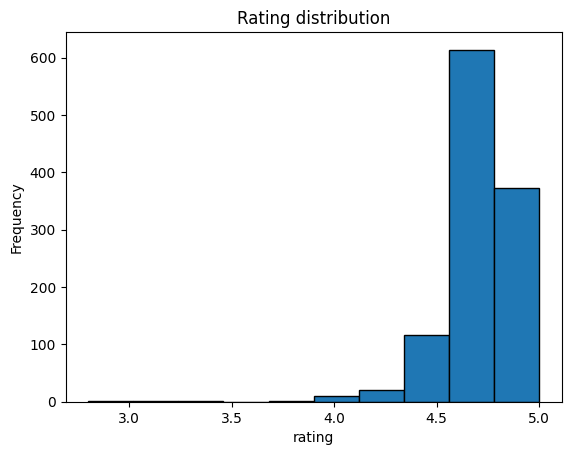

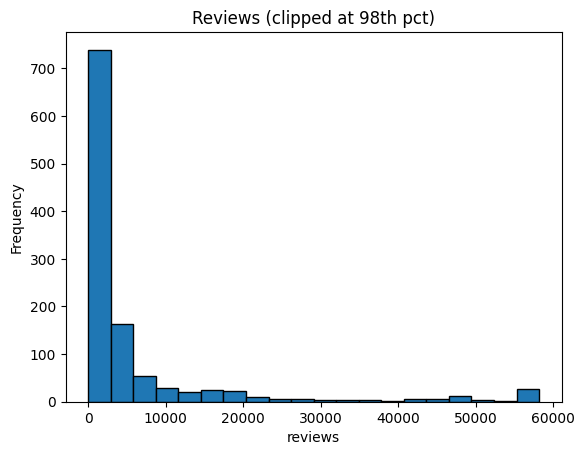

Levels: {'Beginner': 675, 'Intermediate': 200, 'Unknown': 135, 'Mixed': 89, 'Advanced': 36, 'Course': 2, 'Specialization': 1, 'Degree': 1}
Certificate types: {'Course': 499, 'Specialization': 392, 'Professional Certificate': 100, 'Degree': 59, 'Unknown': 23, 'University Certificate': 19, 'Graduate Certificate': 18, 'Mastertrack': 17, 'Guided Project': 9, 'Postgraduate Diploma': 3}
Top skills: [('Leadership and Management', 357), ('Data Analysis', 263), ('Computer Programming', 215), ('Strategy', 214), ('Communication', 211), ('Critical Thinking', 193), ('Problem Solving', 184), ('Strategy and Operations', 184), ('Python Programming', 170), ('Machine Learning', 153), ('Business Analysis', 151), ('Planning', 140), ('Algorithms', 138), ('Finance', 134), ('Decision Making', 134), ('Data Management', 132), ('Marketing', 131), ('Probability & Statistics', 113), ('Cloud Computing', 112), ('General Statistics', 104)]
                count      mean  median
level                                

In [8]:
# === 2. EDA quick looks ===
fig, ax = plt.subplots()
df["rating"].plot.hist(bins=10, edgecolor="k"); ax.set_title("Rating distribution"); ax.set_xlabel("rating"); plt.show()

fig, ax = plt.subplots()
df["reviewcount_num"].apply(lambda x: min(x, df["reviewcount_num"].quantile(0.98))).plot.hist(bins=20, edgecolor="k")
ax.set_title("Reviews (clipped at 98th pct)"); ax.set_xlabel("reviews"); plt.show()

print("Levels:", df["level"].value_counts(dropna=False).to_dict())
print("Certificate types:", df["certificatetype"].value_counts().head(10).to_dict())

# top skills
skills_flat = [s for lst in df["skills_list"] for s in lst]
top_skills = Counter([s.strip() for s in skills_flat if s.strip()]).most_common(20)
print("Top skills:", top_skills)

# Rating by level
print(df.groupby("level")["rating"].agg(["count","mean","median"]).sort_values("mean", ascending=False))


In [9]:
# === 3. Build content model (TF-IDF on skills) ===
skills_corpus = df["skills_list"].apply(lambda xs: ", ".join(xs))
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X = tfidf.fit_transform(skills_corpus)

# precompute popularity-normalized terms for blending
rating = df["rating"].values
pop = np.log1p(df["reviewcount_num"].values)
r_norm = (rating - rating.min()) / (rating.max() - rating.min() + 1e-9)
p_norm = (pop - pop.min()) / (pop.max() - pop.min() + 1e-9)
popularity = 0.6*r_norm + 0.4*p_norm

In [10]:
# === 4. Simple context model ===
LEVELS = ["Beginner","Intermediate","Advanced","Unknown"]

def context_score(idx, level, hours_per_week, device, study_time):
    # level match
    lvl_match = (df.loc[idx, "level"].str.lower() == level.lower()).astype(float).values
    # duration fit
    desired_months = np.clip(hours_per_week/5.0, 0.5, 6)
    dur = df.loc[idx, "duration_months"].values
    dur_fit = np.exp(-((dur - desired_months)**2) / (2*(1.5**2)))
    # device heuristic
    dev_pen = 0.05 * (dur / (dur.max() + 1e-9)) if device == "mobile" else 0.0
    # study_time is placeholder until you have timestamped events
    base = 0.15*dur_fit + 0.08*lvl_match - dev_pen
    return np.clip(base, 0, 1)

def recommend(query_skills: str,
              level="Beginner",
              hours_per_week=6,
              device="desktop",
              study_time="any",
              top_k=10,
              level_filters=None,
              min_rating=4.5):
    # candidate filter
    mask = df["rating"] >= float(min_rating)
    if level_filters:
        mask &= df["level"].isin(level_filters)
    cand_idx = np.where(mask.values)[0]
    if len(cand_idx) == 0:
        return df.head(0)

    # content score
    if query_skills.strip():
        q_vec = tfidf.transform([query_skills.lower()])
        sim = cosine_similarity(q_vec, X[cand_idx]).ravel()
    else:
        sim = np.zeros(len(cand_idx))

    # blend with item popularity
    pop_s = popularity[cand_idx]
    base = 0.7*sim + 0.3*pop_s

    # context rerank
    ctx = context_score(cand_idx, level, hours_per_week, device, study_time)
    score = 0.7*base + 0.3*ctx

    order = cand_idx[np.argsort(-score)][:top_k]
    out = df.loc[order, ["partner","course","level","rating","reviewcount_num","duration_months","certificatetype","skills_list"]].copy()
    out.insert(0, "score", np.sort(score)[::-1][:top_k])
    return out.reset_index(drop=True)

# quick smoke test
display(recommend("python, sql, data analysis", level="Beginner", hours_per_week=5, device="mobile", top_k=5))


,score,partner,course,level,rating,reviewcount_num,duration_months,certificatetype,skills_list
0,0.439488,Google,"Foundations: Data, Data, Everywhere",Beginner,4.8,93900.0,2.0,Course,"[ Data Analysis, SQL, Data Visualization, Business Analysis, Spreadsheet Software, Data Science, Databases, Microsoft Excel]"
1,0.434306,Vanderbilt University,ChatGPT Advanced Data Analysis,Beginner,4.9,93.0,2.0,Course,[ Data Analysis]
2,0.430783,IBM,Introduction to Data Analytics,Beginner,4.8,13500.0,2.0,Course,"[ Data Analysis, Databases, Python Programming, SQL, Data Management, Data Mining, Data Science, NoSQL, R Programming, Microsoft Excel]"
3,0.414083,Coursera Project Network,Understanding Basic SQL Syntax,Beginner,4.7,84.0,0.5,Guided Project,[ SQL]
4,0.389430,Emory University,Qualitative Research Design and Methods for Public Health,Beginner,4.7,165.0,4.5,Specialization,[ Data Analysis]


In [11]:

# === 6. Minimal UI (Colab widgets) ===
query = widgets.Text(value="", description="Skills/Query:", placeholder="e.g. python, sql, ux, cybersecurity")
level_dd = widgets.Dropdown(options=LEVELS, value="Beginner", description="Level:")
hours = widgets.IntSlider(value=6, min=1, max=30, step=1, description="Hours/wk:")
device_dd = widgets.ToggleButtons(options=["desktop","mobile"], value="desktop", description="Device:")
time_dd = widgets.ToggleButtons(options=["morning","evening","any"], value="any", description="Study time:")
min_rating_w = widgets.FloatSlider(value=4.5, min=0.0, max=5.0, step=0.1, description="Min rating:")
levels_ms = widgets.SelectMultiple(options=LEVELS, description="Filter levels:", rows=4)
topk = widgets.IntSlider(value=10, min=3, max=20, step=1, description="Top N:")
run_btn = widgets.Button(description="Recommend", button_style="primary")

out = widgets.Output()

def on_run(_):
    with out:
        clear_output()
        lf = list(levels_ms.value)
        res = recommend(query.value,
                        level=level_dd.value,
                        hours_per_week=hours.value,
                        device=device_dd.value,
                        study_time=time_dd.value,
                        top_k=topk.value,
                        level_filters=lf if lf else None,
                        min_rating=min_rating_w.value)
        if res.empty:
            print("No matches for current filters.")
            return
        display(res)

ui = widgets.VBox([
    widgets.HTML("<h3>Context-Aware Course Recommender (Colab)</h3>"),
    widgets.HBox([query]),
    widgets.HBox([level_dd, device_dd, time_dd]),
    widgets.HBox([hours, topk]),
    widgets.HBox([min_rating_w, levels_ms]),
    run_btn, out
])
run_btn.on_click(on_run)
display(ui)
